In [1]:
import numpy as np
from scipy.fft import *
from skimage import exposure
import cv2
from tqdm import trange

class LIME:
    # initiate parameters
    def __init__(self, iterations, alpha, rho, gamma, strategy, exact):
        self.iterations = iterations
        self.alpha = alpha
        self.rho = rho
        self.gamma = gamma
        self.strategy = strategy
        self.exact = exact

    # load pictures and normalize
    def load(self, imgPath):
        self.loadimage(cv2.imread(imgPath) / 255)

    # initiate Dx,Dy,DTD
    def loadimage(self,L):
        self.L = L
        self.row = self.L.shape[0]
        self.col = self.L.shape[1]

        self.T_esti = np.max(self.L, axis=2)
        self.Dv = -np.eye(self.row) + np.eye(self.row, k=1)
        self.Dh = -np.eye(self.col) + np.eye(self.col, k=-1)

        dx = np.zeros((self.row, self.col))
        dy = np.zeros((self.row, self.col))
        dx[1, 0] = 1
        dx[1, 1] = -1
        dy[0, 1] = 1
        dy[1, 1] = -1
        dxf = fft2(dx)
        dyf = fft2(dy)
        self.DTD = np.conj(dxf) * dxf + np.conj(dyf) * dyf

        self.W = self.Strategy()

    # strategy 2
    def Strategy(self):
        if self.strategy == 2:
            self.Wv = 1 / (np.abs(self.Dv @ self.T_esti) + 1)
            self.Wh = 1 / (np.abs(self.T_esti @ self.Dh) + 1)
            return np.vstack((self.Wv, self.Wh))
        else:
            return np.ones((self.row * 2, self.col))

    # T subproblem
    def T_sub(self, G, Z, miu):
        X = G - Z / miu
        Xv = X[:self.row, :]
        Xh = X[self.row:, :]

        numerator = fft2(2 * self.T_esti + miu * (self.Dv @ Xv + Xh @ self.Dh))
        denominator = self.DTD * miu + 2
        T = np.real(ifft2(numerator / denominator))

        return exposure.rescale_intensity(T, (0, 1), (0.001, 1))

    # G subproblem
    def G_sub(self, T, Z, miu, W):
        epsilon = self.alpha * W / miu
        temp = np.vstack((self.Dv @ T, T @ self.Dh)) + Z / miu
        return np.sign(temp) * np.maximum(np.abs(temp) - epsilon, 0)

    # Z subproblem
    def Z_sub(self, T, G, Z, miu):
        return Z + miu * (np.vstack((self.Dv @ T, T @ self.Dh)) - G)

    # miu subproblem
    def miu_sub(self, miu):
        return miu * self.rho

    def run(self):
        # accurate algorithm
        if self.exact:
            T = np.zeros((self.row, self.col))
            G = np.zeros((self.row * 2, self.col))
            Z = np.zeros((self.row * 2, self.col))
            miu = 1

            for i in trange(0,self.iterations):
                T = self.T_sub(G, Z, miu)
                G = self.G_sub(T, Z, miu, self.W)
                Z = self.Z_sub(T, G, Z, miu)
                miu = self.miu_sub(miu)

            self.T = T ** self.gamma
            self.R = self.L / np.repeat(self.T[..., None], 3, axis = -1)
            return exposure.rescale_intensity(self.R,(0,1)) * 255
        # TODO: rapid algorithm
        else:
            pass

In [3]:
def main():
    #load
    filePath = "/kaggle/input/low-light-proj/Train/low/102.png"
    # initiate LIME operator and load pictures
    lime = LIME(iterations=2,alpha=0.15,rho=1.1,gamma=0.6,strategy=2,exact=True)
    lime.load(filePath)
    # run
    R = lime.run()
    # save results
    #filename = os.path.split(filePath)[-1]
    savePath = "/kaggle/working/pics_dual_enh.png"
    cv2.imwrite(savePath, R)

In [4]:
import os
import cv2

#def main():
#    filePath = "/kaggle/input/low-light-proj/Train/low/102.png"
#    dual = DUAL(iterations=2, alpha=0.15, rho=1.1, gamma=0.6, limestrategy=3)
#    dual.load(filePath)
#    dual.run()

if __name__ == "__main__":
    main()

100%|██████████| 2/2 [00:00<00:00,  8.21it/s]


In [5]:
from math import log10, sqrt 
import cv2 
import numpy as np 

def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    abs_er = np.abs(original - compressed)
    mae = np.mean(abs_er)
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    print ("psnr: ",psnr,'mse: ',mse,'mae: ',mae)

In [6]:
og = "/kaggle/input/low-light-proj/Train/low/102.png"
pred = "/kaggle/working/pics_dual_enh.png"

In [7]:
import matplotlib.pyplot as plt
import cv2 as cv

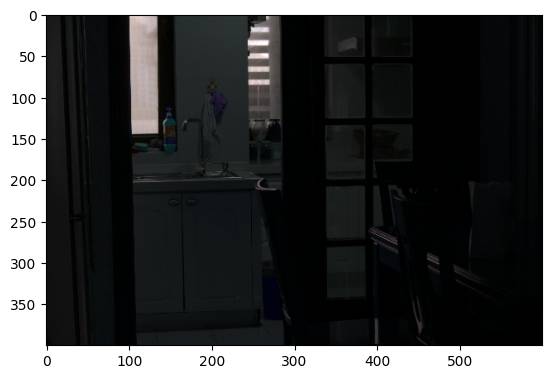

In [8]:
plt.imshow(cv.imread(og))

In [14]:
cv.imread(pred).shape

(400, 600, 3)

In [ ]:
plt.imshow(cv.imread(pred))

In [16]:
PSNR(cv2.imread(og),cv2.imread(pred))

psnr:  28.095004883757856 mse:  100.82770277777777 mae:  179.74969444444446
